# Algorithm Cage Match

This notebook generates sets of fake STTCs from PTCs, and determines the mean square error produced by TEPs-I, Bagheri and my count matching algorithms.

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [62]:
rdr = reader.Reader(vol_conn)
rdr.read()
gf.get_growth_factors(rdr)

In [3]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

Prune any STTCs that have the same count ID as a PTC.

In [4]:
common_count_ids = list(set(rdr.ptcs.keys()).intersection(set(rdr.sttcs.keys())))
for count_id in common_count_ids:
    del rdr.sttcs[count_id]

In [5]:
list(set(rdr.ptcs.keys()).intersection(set(rdr.sttcs.keys())))

[]

## Population analysis

In [6]:
sttc_n_years = [len(x.data.index.levels[0]) for x in rdr.sttcs.values()]
ptc_n_years = [len(x.data['AADT'].index) for x in rdr.ptcs.values()]

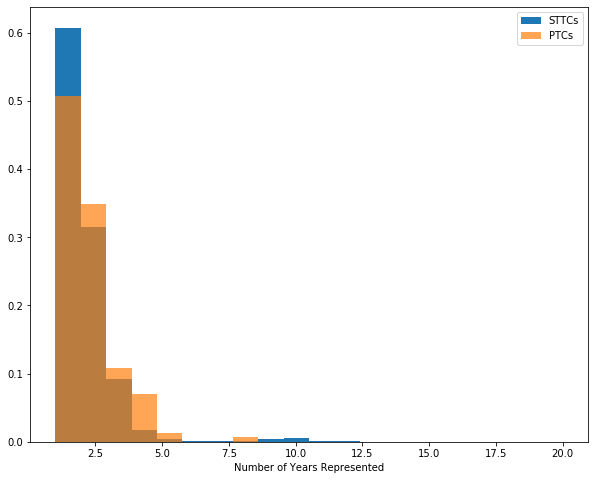

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_n_years, bins=20, range=(1, 20), density=True, label='STTCs');
ax.hist(ptc_n_years, bins=20, range=(1, 20), density=True, alpha=0.7, label='PTCs')
ax.legend(loc=1)
ax.set_xlabel("Number of Years Represented");

In [8]:
sttc_dyears = [max(x.data.index.levels[0]) - min(x.data.index.levels[0]) for x in rdr.sttcs.values()]
ptc_dyears = [max(x.data['AADT'].index) - min(x.data['AADT'].index) for x in rdr.ptcs.values()]

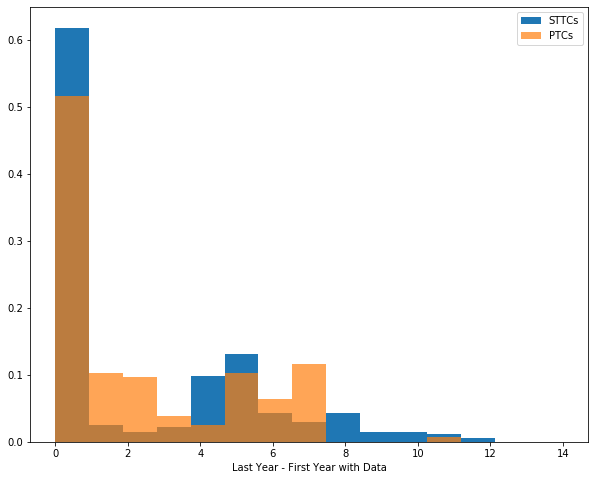

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_dyears, bins=15, range=(0, 14), density=True, label='STTCs');
ax.hist(ptc_dyears, bins=15, range=(0, 14), density=True, alpha=0.7, label='PTCs')
ax.legend(loc=1)
ax.set_xlabel("Last Year - First Year with Data");

In [10]:
sttc_startyears = [min(x.data.index.levels[0]) for x in rdr.sttcs.values()]
ptc_startyears = [min(x.data['AADT'].index) for x in rdr.ptcs.values()]

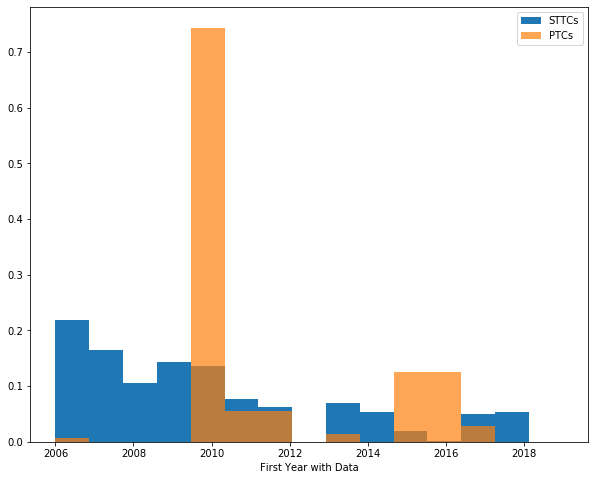

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_startyears, bins=15, range=(2006, 2019), density=True, label='STTCs');
ax.hist(ptc_startyears, bins=15, range=(2006, 2019), density=True, alpha=0.7, label='PTCs')
ax.legend(loc=1)
ax.set_xlabel("First Year with Data");

## STTC-MC generator

This routine randomly generates a set of STTCs.  The goal is to generate a set of short term counts that have roughly the same monthly and day-of-month properties as the true short term count data, but are drawn from a sample where true AADTs can be calculated.  The procedure is:

- Select a year (I think 2016, 2018 and 2020 makes sense).
- Cycle through PTCs.  For each PTC:
  - Randomly select an STTC (of the same direction).
  - Check if there are more years in the STTC than the PTC (unlikely); if so, select another STTC at random.
  - Perform a mapping between the years of the PTC and STTC using `get_closest_year`.  For non-unique mappings, drop data as necessary.
  - For each year of STTC data, find the earliest daily count, and find the closest date represented in the PTC.  Then, map the subsequent dates in the STTC data to their PTC counterparts (see implementation below).
  - Once all the STTC daily counts are selected for, we've generated a fake STTC site; move on to the next PTC.

In [12]:
# Get STTC count IDs. Randomize their orders.
sttc_count_ids = np.array(sorted(rdr.sttcs.keys()))
sttc_negative_count_ids = sttc_count_ids[sttc_count_ids < 0]
sttc_positive_count_ids = sttc_count_ids[sttc_count_ids > 0]
np.random.shuffle(sttc_negative_count_ids)
np.random.shuffle(sttc_positive_count_ids)

In [13]:
ptc = list(rdr.ptcs.values())[42]
ptc.count_id

-1147201

In [14]:
sttc_count_ids = sttc_negative_count_ids if ptc.direction < 0 else sttc_positive_count_ids
# Select an STTC.
for i in range(len(sttc_count_ids)):
    sttc = rdr.sttcs[sttc_count_ids[i]]
    sttc_years = sttc.data['Date'].index.levels[0].values
    ptc_years = ptc.data['AADT'].index.values
    # Check if the STTC has more years of data than the PTC - if not,
    # use the chosen STTC.
    if sttc_years.shape[0] <= ptc_years.shape[0]:
        break

# Remove the STTC ID from future consideration.
sttc_count_ids = np.delete(sttc_count_ids, i)

In [15]:
sttc.count_id in sttc_count_ids

False

In [16]:
sttc.direction == ptc.direction

True

In [17]:
import countmatch_common as cmc

def get_year_mapping(sttc_years, ptc_years):
    # Produce a one-to-one mapping between STTC and PTC year.
    if len(sttc_years) > len(ptc_years):
        raise ValueError('more STTC years required than available in PTC!')
    sttc_years_l = np.sort(sttc_years)
    ptc_years_l = np.sort(ptc_years)
    year_mapping = {}
    get_year_mapping_recursion(sttc_years_l, ptc_years_l, year_mapping)
    return year_mapping


def get_year_mapping_recursion(sttc_years, ptc_years, year_mapping):
    if len(sttc_years) == 1:
        year_mapping[sttc_years[0]] = cmc.get_closest_year(sttc_years[0], ptc_years)
    else:
        closest_years = cmc.get_closest_year(
            np.array([sttc_years[0], sttc_years[-1]]), ptc_years)
        if (abs(closest_years[0] - sttc_years[0]) >=
                abs(closest_years[1] - sttc_years[-1])):
            year_mapping[sttc_years[-1]] = closest_years[1]
            i_cpy = np.where(ptc_years == closest_years[1])[0][0]
            get_year_mapping_recursion(
                sttc_years[:-1], np.delete(ptc_years, i_cpy),
                year_mapping)
        else:
            year_mapping[sttc_years[0]] = closest_years[0]
            i_cpy = np.where(ptc_years == closest_years[0])[0][0]
            get_year_mapping_recursion(
                sttc_years[1:], np.delete(ptc_years, i_cpy),
                year_mapping)

In [18]:
get_year_mapping([2009, 2013, 2019], [2009, 2010, 2011])

{2009: 2009, 2013: 2011, 2019: 2010}

Okay that's crap.

In [20]:
def get_year_mapping(sttc_years, ptc_years):
    # Produce a one-to-one mapping between STTC and PTC year.
    if len(sttc_years) > len(ptc_years):
        raise ValueError('more STTC years required than available in PTC!')
    
    if len(sttc_years) == 1:
        closest_year = cmc.get_closest_year(sttc_years[0], np.array(ptc_years))
        return {sttc_years[0]: closest_year}
        
    # Create sorted copies of the years.
    sttc_years = np.sort(sttc_years)
    ptc_years = np.sort(ptc_years)

    # Create 'rescaled_sttc_years', so that get_closest_year can map two
    # very different year ranges together.  I'd prefer to do a fit here,
    # but we can't guarantee sttc_years has the same length as ptc_years.
    slope = ((ptc_years[-1] - ptc_years[0]) /
             (sttc_years[-1] - sttc_years[0]))
    rescaled_sttc_years = slope * (sttc_years - sttc_years[0]) + ptc_years[0]
    closest_years = cmc.get_closest_year(rescaled_sttc_years, ptc_years)
    
    year_mapping = {}
    for i in range(len(sttc_years)):
        if closest_years[i] not in year_mapping.values():
            year_mapping[sttc_years[i]] = closest_years[i]

    return year_mapping

get_year_mapping([2009, 2018, 2019, 2027], [2006, 2012, 2013, 2014])

{2009: 2006, 2018: 2012, 2027: 2014}

In [21]:
get_year_mapping([2010], [2006, 2012, 2013, 2014])

{2010: 2012}

In [22]:
get_year_mapping([2006, 2007, 2008], [2006, 2017, 2019, 2021])

{2006: 2006, 2007: 2017, 2008: 2021}

In [23]:
get_year_mapping([2006, 2017, 2028], [2006, 2007, 2008, 2009])

{2006: 2006, 2017: 2007, 2028: 2009}

In [24]:
get_year_mapping([2006, 2017], [2006, 2007, 2008, 2009])

{2006: 2006, 2017: 2009}

In [25]:
get_year_mapping([2006, 2017], [2006, 2017, 2018, 2019])

{2006: 2006, 2017: 2019}

In [26]:
get_year_mapping([2006, 2017, 2023, 2027], [2006, 2017, 2018, 2019])

{2006: 2006, 2017: 2017, 2027: 2019}

In [27]:
get_year_mapping([2006, 2017, 2023, 2027], [2018, 2019])

ValueError: more STTC years required than available in PTC!

Okay that's a half-reasonable year interpolator.

In [43]:
year_mapping = get_year_mapping(sttc_years, ptc_years)
year_mapping

{2008: 2010, 2012: 2016, 2014: 2017}

In [40]:
sttc.data['Date'].loc[2008].apply(lambda x: x.replace(year=2010))

Day of Year
92   2010-04-01
93   2010-04-02
94   2010-04-03
Name: Date, dtype: datetime64[ns]

In [44]:
def get_sample_request(sttc, year, ptc_year):
    date_sample = pd.DataFrame({
        'Date': sttc.data.loc[year]['Date'].apply(lambda x: x.replace(year=ptc_year))})
    date_sample['Month'] = date_sample['Date'].dt.month
    date_sample['Day of Week'] = date_sample['Date'].dt.month
    return (date_sample.groupby('Month')['Date']
            .agg(['min', 'count'])
            .rename(columns={'min': 'Start Date', 'count': 'N_days'}))


def nearest_idx_factory(ptc_daily_counts):
    ptc_date_idxs = pd.Series(ptc_daily_counts.index,
                              index=ptc_daily_counts['Date'].values)
    return lambda x: ptc_date_idxs.index.get_loc(x, method='nearest')


get_sample_request(sttc, 2012, year_mapping[2012])

,Start Date,N_days
Month,,
11,2016-11-13,3


In [47]:
daily_counts = []
for year in sttc_years:
    ptc_year = year_mapping[year]
    sample_request = get_sample_request(sttc, year, ptc_year)

    ptc_daily_counts = ptc.data['Daily Count'].loc[ptc_year]
    nearest_idx = nearest_idx_factory(ptc_daily_counts)
    
    iloc_idxs = []
    for _, row in sample_request.iterrows():
        idx = nearest_idx(row['Start Date'])
        iloc_idxs += list(range(idx, idx + row['N_days']))
    
    sample = ptc_daily_counts.iloc[iloc_idxs, :].copy()
    sample.index = pd.MultiIndex.from_product(
        [[ptc_year, ], sample.index],
        names=['Year', sample.index.name])
    daily_counts.append(sample)

In [48]:
import sys
sys.path.append('../')
from traffic_prophet.countmatch import reader

In [50]:
fake_sttc = reader.Count(ptc.count_id, ptc.centreline_id, ptc.direction,
                         pd.concat(daily_counts), is_permanent=False)

In [51]:
fake_sttc.centreline_id

1147201

In [52]:
fake_sttc.data

Date  Daily Count
Year Day of Year                        
2010 91          2010-04-01      19496.0
     92          2010-04-02      11034.0
     93          2010-04-03      10602.0
2016 318         2016-11-13      10712.0
     319         2016-11-14      11013.0
     320         2016-11-15      12355.0
2017 273         2017-09-30      10947.0
     274         2017-10-01       9193.0
     275         2017-10-02      10509.0

### Put it all together

In [88]:
import importlib
import countmatch_validator as cmv
importlib.reload(cmv)

<module 'countmatch_validator' from '/home/cczhu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_validator.py'>

In [89]:
fake_data = cmv.generate_test_data(rdr)

In [90]:
fake_data.sttcs[-913864].data

Date  Daily Count
Year Day of Year                        
2016 260         2016-09-16      54340.0
     261         2016-09-17      50458.0
     262         2016-09-18      52963.0

In [93]:
fake_dataset = cmv.generate_test_database(rdr, n_sets=10, progress_bar=True)